# Twitter Data Preprocessing

Importing all libraries. 

In [1]:
# Imports

import glob
import string
import ast

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# nltk
from nltk.tag import pos_tag
import nltk

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold


#metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Importing Dataset
We import the CSV files

In [2]:
all_data = pd.DataFrame()
for f in glob.glob("./cleanedData/Cleaned_TrainData.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

In [3]:
test_all_data = pd.DataFrame()
for f in glob.glob("./cleanedData/Cleaned_TestData.csv"):
    df = pd.read_csv(f)
    test_all_data = all_data.append(df,ignore_index=True)

In [4]:
all_data.info()
all_data = all_data.sample(frac=1).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 20 columns):
id                       2797 non-null object
id_str                   2797 non-null object
screen_name              2797 non-null object
location                 1754 non-null object
description              2395 non-null object
url                      1392 non-null object
followers_count          2797 non-null int64
friends_count            2797 non-null int64
listedcount              2797 non-null int64
created_at               2797 non-null object
favourites_count         2797 non-null int64
verified                 2797 non-null bool
statuses_count           2797 non-null int64
lang                     2797 non-null object
status                   2683 non-null object
default_profile          2797 non-null bool
default_profile_image    2797 non-null bool
has_extended_profile     2791 non-null object
name                     2797 non-null object
bot                      2797 

In [5]:
test_all_data.head(1)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.16E+17,8.16E+17,HoustonPokeMap,"Houston, TX","Rare and strong Pokթmon in Houston, TX. See mo...",https://t.co/dnWuDbFRkt,1520,0,10,1/2/17 2:25,0,False,133104,en,"Status(contributors=None, truncated=False, tex...",True,False,False,Houston Pokթ Alert,1.0


In [6]:
train, validationSet = train_test_split(all_data, test_size = 0.2)

In [7]:
train.shape , validationSet.shape

((2237, 20), (560, 20))

# Visualizing Data

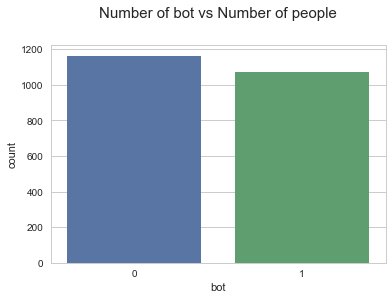

In [94]:
plt.title('Number of bot vs Number of people', y=1.1, size=15)
sns.countplot('bot', data=train)

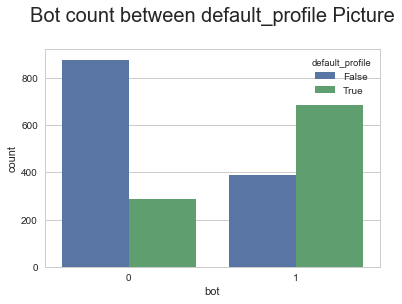

In [95]:
plt.title('Bot count between default_profile Picture', size=20, y=1.1)
sns.countplot(x = 'bot', hue='default_profile', data=train)

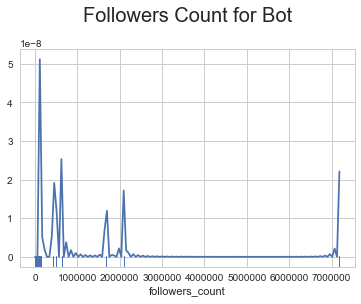

In [96]:
plt.title('Followers Count for Bot', size=20, y=1.1)
df1 = train[['followers_count','bot']]
bot_len  = df1.ix[(df1['bot']==1)]
sns.distplot(bot_len['followers_count'], rug=True, hist=False)

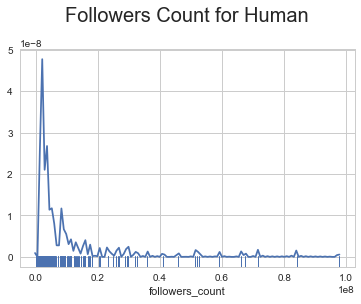

In [97]:
plt.title('Followers Count for Human', size=20, y=1.1)
df1 = train[['followers_count','bot']]
bot_len  = df1.ix[(df1['bot']==0)]
sns.distplot(bot_len['followers_count'], rug=True, hist=False)

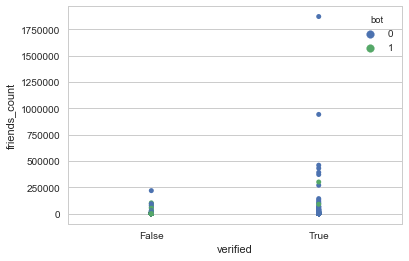

In [98]:
ax = sns.stripplot(x="verified", y="friends_count", hue="bot",data=train)

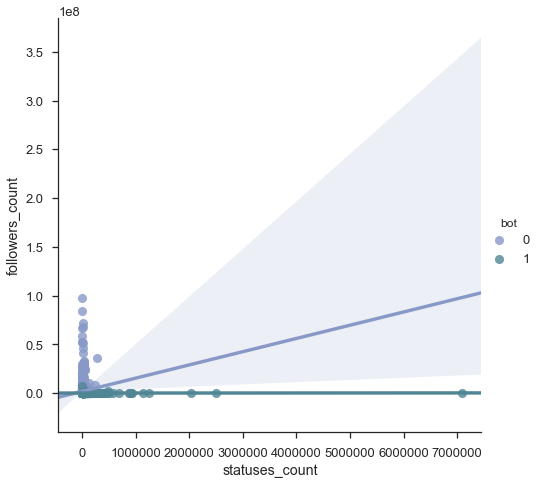

In [99]:
import seaborn as sns
sns.set(style="ticks", context="talk")
pal = sns.cubehelix_palette(4, 1.5, .75, light=.6, dark=.2)
g = sns.lmplot(x="statuses_count", y="followers_count", hue="bot", data=train,
               palette=pal, size=7)
g.set_axis_labels("statuses_count", "followers_count")

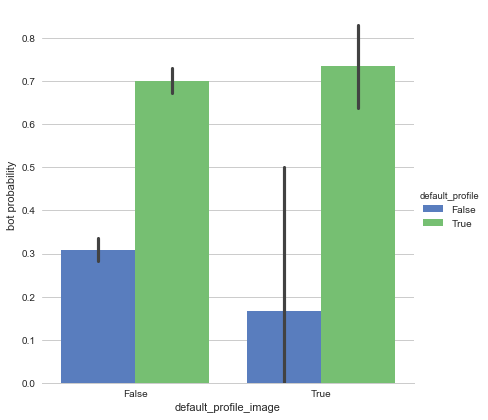

In [100]:
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="default_profile_image", y="bot", hue="default_profile", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("bot probability")

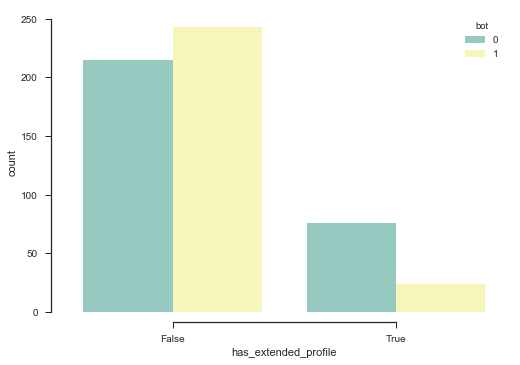

In [101]:
sns.set(style="ticks")
sns.countplot(x="has_extended_profile", hue="bot", data=test, palette="Set3")
sns.despine(offset=10, trim=True)

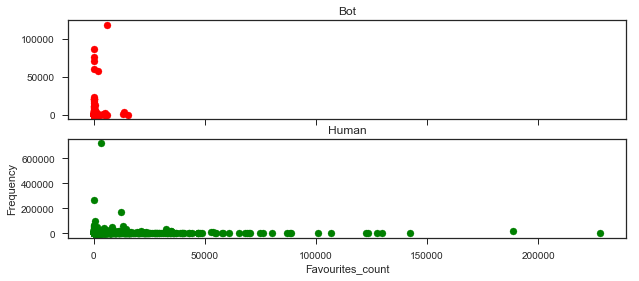

In [102]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

bins = 2

ax1.scatter(train.listedcount[train.bot == 1],train.favourites_count[train.bot == 1],c='r')
ax1.set_title('Bot')

ax2.scatter( train.listedcount[train.bot == 0],train.favourites_count[train.bot == 0],c='g')
ax2.set_title('Human')

plt.xlabel('Favourites_count')
plt.ylabel('Frequency')
plt.show()

# Transforming Features

In [8]:
def returnDates(x,valid):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}    
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 2:
        _date = date_split[0].split('/')
        _date[2] = '20'+_date[2]
        formated_date = '/'.join(map(str,_date))
        time = date_split[1]
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
    if valid:
        return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    else:
        return pd.to_datetime(time,format='%H:%M').hour

In [9]:
def lexical_diversity(text):
  if len(text) == 0:
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity

def return_dict(x):
    if not pd.isnull(x) and x.find('_json=') != -1:
        x = x[x.find('_json=')+6:x.find(', coordinates=')]
        x = ast.literal_eval(x)
        return x
    else:
        return None

def status_created_date(x):
    if not pd.isnull(x):
        x = return_dict(x)
        if x is not None:
            x = returnDates(x['created_at'],True)
            return x
    return pd.to_datetime('05/05/2017', format='%m/%d/%Y', errors='coerce')

    
def get_Noun(x):
    word = str(x).strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
    return count

def nameR(x):
    wordlen = len(str(x).strip().split())
    letters = len(''.join(str(x).strip().split()))
    return letters/wordlen

In [10]:
def status_created_at(df):
    df['status_created_at'] = df.status.apply(status_created_date)
    return df

def ff_ratio(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    df.loc[:,'ff_ratio'] = (df.followers_count/df.friends_count)
    return df

def tweets_per_day(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    df.loc[:,'tweets_per_day'] = df.statuses_count/df.acc_age
    return df

def simplfy_followerscount(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    return df  

def simplfy_friendscount(df):
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    return df    

def simplfy_listedcount(df):
    df.listedcount= df.listedcount.apply(lambda x: int(x)+1)
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    return df 

def drop_features(df):
    return df.drop(['id', 'id_str', 'location','lang','status','created_at'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def diversity(df):
    df.loc[:,'description'].fillna("")    
    df.loc[:,'sn_length'] = df.screen_name.apply(lambda text: len(str(text)))
    df.loc[:,'desc_length'] = df.description.apply(lambda text: len(str(text)))
    grouped = df['screen_name']
    df['diversity'] = grouped.apply(lexical_diversity)
    df.loc[:,'null_url'] = df.url.apply(lambda x: 1 if (str(x).find('http'))!=-1 else 0)
    df.loc[:,"botname"] = df.screen_name.apply(lambda x: 1 if ('bot' in x.lower()) else 0)
    df.loc[:,"nameratio"] = df.name.apply(lambda x: nameR(x))
    return df

def account_age(df):
    df['acc_age'] = (df['status_created_at'] - df['modified_date'])
    df['acc_age'] = df.acc_age.apply(lambda  x:int(x.days))
    for index,row in df.iterrows():
        if row['acc_age'] < 0:
            value = abs(int((pd.to_datetime('05/05/2017', format='%m/%d/%Y', errors='coerce') - pd.to_datetime(row['modified_date'])).days))
            df.set_value(index,'acc_age',value)
    df['acc_age'] += 1
    return df;

In [11]:
def transform_features(df):
    df = status_created_at(df)
    df = format_date(df)
    df = account_age(df)
    df = tweets_per_day(df)
    df = ff_ratio(df)
    df = simplfy_followerscount(df)
    df = simplfy_friendscount(df)
    df = simplfy_listedcount(df)
    df = simplfy_favouritescount(df)
    df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = diversity(df)
    df = drop_features(df)
    return df

train = transform_features(train)
validationSet = transform_features(validationSet)
test_all_data = transform_features(test_all_data)
train.head(3)

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,...,modified_hour,acc_age,tweets_per_day,ff_ratio,sn_length,desc_length,diversity,null_url,botname,nameratio
1719,tushar141990,NaN,NaN,66,287,3,18,False,85,True,...,18,2729,0.030781,0.227273,12,3,0.833333,0,0,8
815,pikachaplin,Reimagining Charlie Chaplin movies within the ...,NaN,58,3,15,2,False,8263,False,...,5,409,20.200489,28.500000,11,98,0.727273,0,0,11
446,ThaboSefolosha,"Proud father of 2 _��__��_, husband of a _���_...",https://t.co/dJKVzmYpui,138873,219,1502,7,True,999,False,...,6,2967,0.336367,637.027523,14,134,0.714286,1,0,7


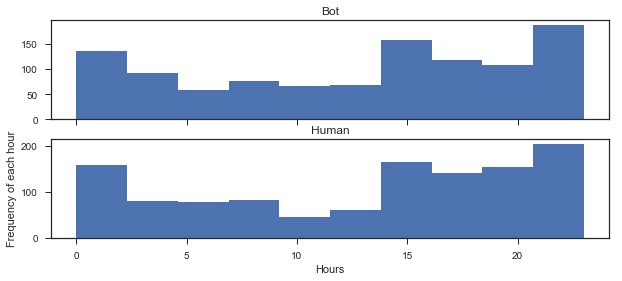

In [107]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

bins = 30

ax1.hist(train.modified_hour[train.bot == 1])
ax1.set_title('Bot')

ax2.hist(train.modified_hour[train.bot == 0])
ax2.set_title('Human')

plt.xlabel('Hours')
plt.ylabel('Frequency of each hour')
plt.show()

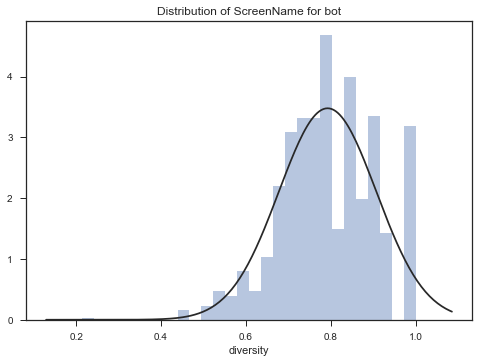

In [108]:
df1 = train[['diversity','bot']]
bot_ = df1.ix[(df1['bot']==1)]
Nonbot_ = df1.ix[(df1['bot']==0)]
from scipy.stats import norm
ax = sns.distplot(bot_['diversity'], fit=norm, kde=False)
plt.title('Distribution of ScreenName for bot')

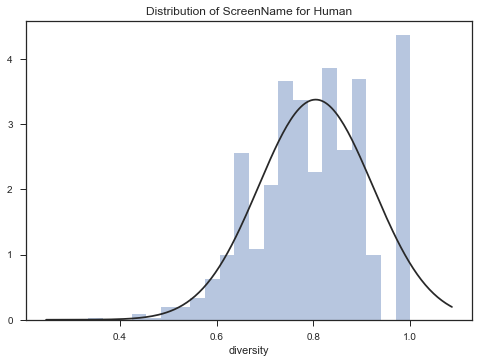

In [109]:
ax = sns.distplot(Nonbot_['diversity'], fit=norm, kde=False)
plt.title('Distribution of ScreenName for Human')

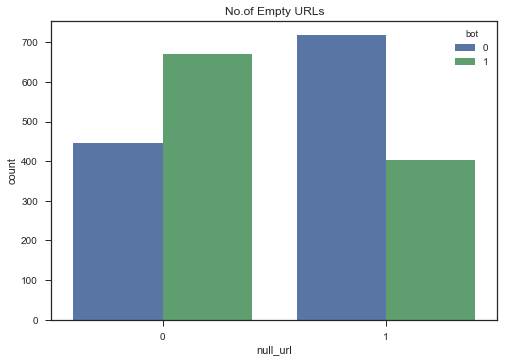

In [110]:
sns.countplot(x ='null_url', hue='bot' ,data=train)
plt.title("No.of Empty URLs")

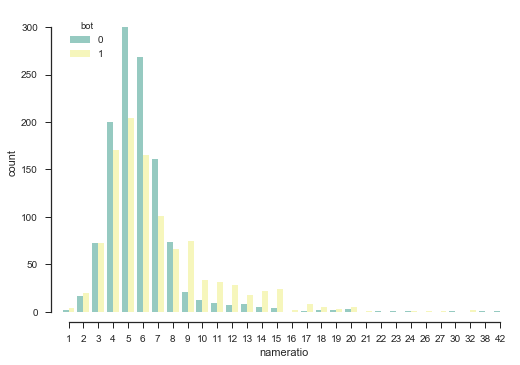

In [26]:
sns.set(style="ticks")
sns.countplot(x="nameratio", hue="bot", data=train, palette="Set3")
sns.despine(offset=10, trim=True)

# Final Encoding

The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.

In [12]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count', \
                'default_profile','default_profile_image','has_extended_profile','modified_hour','acc_age','tweets_per_day',\
                'ff_ratio','sn_length','desc_length',\
                'diversity','null_url']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train.loc[:,feature] = le.transform(df_train[feature])
        df_test.loc[:,feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, validationSet = encode_features(train, validationSet)
train.head()

,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,...,modified_hour,acc_age,tweets_per_day,ff_ratio,sn_length,desc_length,diversity,null_url,botname,nameratio
1719,tushar141990,NaN,NaN,64,257,2,17,0,80,1,...,18,1310,181,465,10,1,32,0,0,8
815,pikachaplin,Reimagining Charlie Chaplin movies within the ...,NaN,56,1,14,1,0,1305,0,...,5,311,2330,1485,9,96,24,0,0,11
446,ThaboSefolosha,"Proud father of 2 _��__��_, husband of a _���_...",https://t.co/dJKVzmYpui,1158,202,419,6,1,493,0,...,6,1478,551,2044,12,132,23,1,0,7
1511,angelia_irr,NaN,NaN,0,24,0,96,0,154,1,...,15,25,1874,204,9,1,24,0,0,5
2378,hexa_tech,The all-in-one solution for team collaboration...,https://t.co/MLcxO7CW7K,423,685,4,2,0,100,0,...,0,372,432,745,7,132,28,1,0,4


In [13]:
X_all = train.drop(['screen_name','description','modified_date','status_created_at','url','name','bot'], axis=1)
y_all = train['bot']

In [14]:
X_all.shape, y_all.shape

((2237, 19), (2237,))

In [15]:
X_all.head(1)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,modified_hour,acc_age,tweets_per_day,ff_ratio,sn_length,desc_length,diversity,null_url,botname,nameratio
1719,64,257,2,17,0,80,1,0,0,18,1310,181,465,10,1,32,0,0,8


# Feature Selection

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Having too many irrelevant features in your data can decrease the accuracy of the models. Three benefits of performing feature selection before modeling your data are:

* Reduces Overfitting
* Improves Accuracy
* Reduces Training

###  Recursive Feature Elimination
The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes and building a model on those attributes that remain.

Optimal number of features : 15


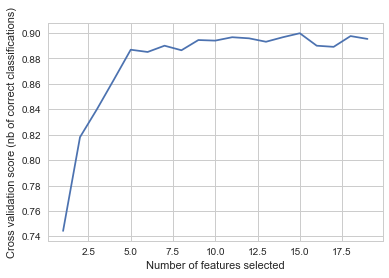

In [55]:
# Create the RFE object and compute a cross-validated score.
model = ExtraTreesClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10),scoring='accuracy')
rfecv.fit(X_all, y_all)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

So the optimal number of features to proceed with is 11, will use the DecisionTree and with feature importance function, we can filter out the top 11 features

In [56]:
from sklearn.ensemble import ExtraTreesClassifier
model2 = ExtraTreesClassifier()
model2.fit(X_all, y_all)

#Add features and their importances to a dictionary
feature_imp_dict = dict(zip(X_all.columns.values, model2.feature_importances_))

for x in sorted(zip(model2.feature_importances_,list(X_all))):
    print x

(0.0079222809126051046, 'default_profile_image')
(0.021221880630855505, 'diversity')
(0.021573572131577144, 'sn_length')
(0.022233436455599359, 'botname')
(0.023827094444721, 'nameratio')
(0.023981331371228827, 'modified_hour')
(0.026023620929600054, 'desc_length')
(0.027701671181606463, 'null_url')
(0.027876215760560451, 'has_extended_profile')
(0.041020574274982749, 'listedcount')
(0.041426438954988584, 'followers_count')
(0.047932548377691994, 'statuses_count')
(0.057043387571972672, 'friends_count')
(0.057457922007134773, 'default_profile')
(0.058700301278534296, 'ff_ratio')
(0.063086956589902959, 'tweets_per_day')
(0.078700223753956508, 'verified')
(0.090961863943569046, 'favourites_count')
(0.26130867942891245, 'acc_age')


So after the feature selection, we pick the top 6 features as,
1. acc_age
2. favourites_count
3. listedcount
4. friends_count
5. tweets_per_day
6. ff_ratio
7. verified
8. default_profile
9. statuses_count
10. followers_count
11. desc_length

In [57]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

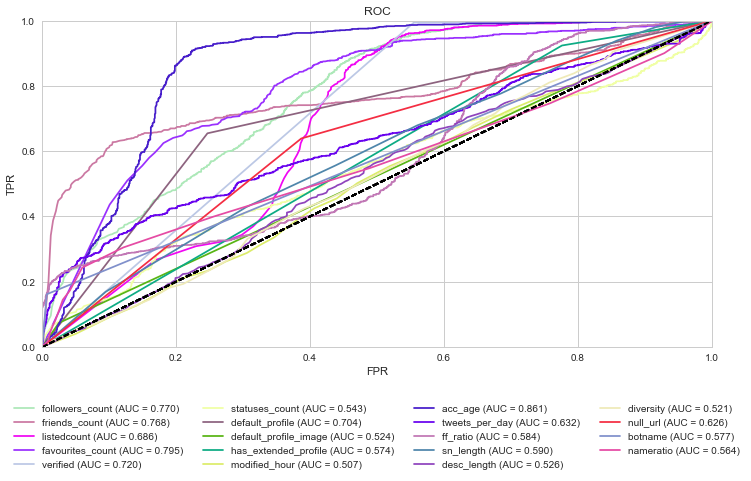

In [58]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

#Student put code here
feature_auc_dict = {}
for col in X_all.columns:
    feature_auc_dict[col] = plotUnivariateROC(X_all[col], y_all, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [59]:
#Add auc and mi each to a single dataframe
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_imp = pd.DataFrame(pd.Series(feature_imp_dict), columns = ['imp'])

#Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_imp, left_index = True, right_index = True)
feat_imp_df

,auc,imp
acc_age,0.860618,0.261309
botname,0.577260,0.022233
default_profile,0.703993,0.057458
default_profile_image,0.524203,0.007922
desc_length,0.525566,0.026024
diversity,0.520712,0.021222
favourites_count,0.794833,0.090962
ff_ratio,0.583799,0.058700
followers_count,0.770057,0.041426
friends_count,0.768291,0.057043


To put the different metrics on the same scale, we'll use pandas rank() method for each feature.

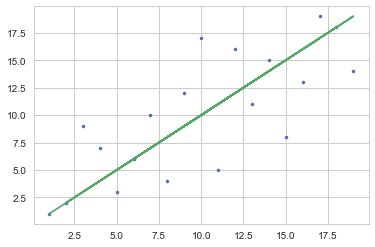

In [60]:
#Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)

#Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.imp, '.')
#Plot a y=x reference line
plt.plot(feat_ranks.auc, feat_ranks.auc,)

In [61]:
#Now create lists of top 10 features for both auc and mi
top5_auc = list(feat_ranks[(feat_ranks.auc <= 10)].index.values)
top5_imp = list(feat_ranks[(feat_ranks.imp <= 10)].index.values)
top5_auc, top5_imp

(['acc_age',
  'default_profile',
  'favourites_count',
  'followers_count',
  'friends_count',
  'listedcount',
  'null_url',
  'sn_length',
  'tweets_per_day',
  'verified'],
 ['acc_age',
  'default_profile',
  'favourites_count',
  'ff_ratio',
  'followers_count',
  'friends_count',
  'listedcount',
  'statuses_count',
  'tweets_per_day',
  'verified'])

# Models

### Baseline Model

In [24]:
#baseline model
Mcc_pred = all_data
Mcc_pred['pred'] = 0
accuracy_score(Mcc_pred['pred'],Mcc_pred['bot'])

0.52341794780121553

In [25]:
X_train = train.drop(['bot','screen_name','description','url','name',\
                    'default_profile_image', 'modified_hour',\
                    'diversity','null_url','status_created_at','modified_date'], axis=1) 
y_train = train['bot']

X_test = validationSet.drop(['bot','screen_name','description','url','name',\
                    'default_profile_image','modified_hour', \
                    'diversity','null_url','status_created_at','modified_date'], axis=1)
y_test = validationSet['bot']

In [62]:
X_train.shape,  y_train.shape

((2237, 15), (2237,))

In [63]:
X_test.shape, y_test.shape

((560, 15), (560,))

In [28]:
X_train.head(1)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,has_extended_profile,acc_age,tweets_per_day,ff_ratio,sn_length,desc_length,botname,nameratio
1719,64,257,2,17,0,80,1,0,1310,181,465,10,1,0,8


### Decision Tree

In [45]:
# Decision Tree

clf = DecisionTreeClassifier()

parameters = {'max_features': [10,12,14,15], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [3, 5, 6, 8, 10], 
              'min_samples_split': [10, 20, 30],
              'min_samples_leaf': [1,5,8],
              'min_impurity_split': [0.00000001, 0.0000001]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=8, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
export_graphviz(clf,out_file='tree.dot') 

In [46]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.882142857143


In [48]:
print np.array(cross_val_score(clf, X_train, y_train, cv=10) ).mean()

0.873969499609


In [49]:
print classification_report(y_test,predictions)

             precision    recall  f1-score   support

          0       0.87      0.91      0.89       290
          1       0.90      0.85      0.87       270

avg / total       0.88      0.88      0.88       560



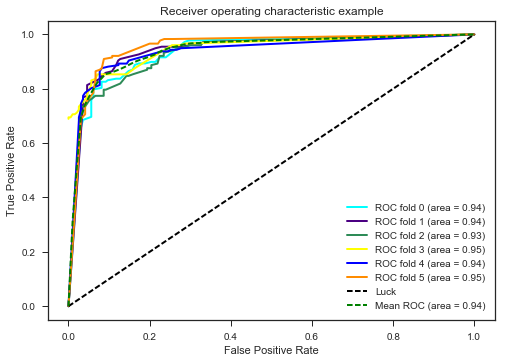

In [50]:
X = X_train.as_matrix()
y = y_train.as_matrix()
n_samples, n_features = X.shape

cv = StratifiedKFold(n_splits=6)
classifier = clf

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

###  Logistic Regression

In [29]:
#Use Kfold to create 5 folds
kfolds = KFold(X_train.shape[0], n_folds = 5)

In [30]:
#1st, set up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-3, 3)], 'penalty':['l1', 'l2']}

#2nd, call the GridSearchCV class, use LogisticRegression and 'log_loss' for scoring
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'log_loss') 
lr_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print(best_1)

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/sco

-0.289790673119


In [31]:
#Next let's look at the best-estimator chosen to see what the parameters were
lr_grid_search.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = [('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

#Now set up the pipeline
pipeline = Pipeline(steps)

#Now set up the parameter grid, paying close to the correct convention here
parameters_scaler = dict(lr__C = [10**i for i in range(-3, 3)],
                  lr__penalty = ['l1', 'l2'])

#Now run another grid search
lr_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = kfolds, scoring = 'log_loss')
lr_grid_search_scaler.fit(X_train, y_train)


#Again, print the score of the best model
best_2 = lr_grid_search_scaler.best_score_
print(best_2)

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/sco

-0.289774480647


/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/sco

In [43]:
#Let's see the model after scaling. Did the optimal parameters change?
lr_grid_search_scaler.best_estimator_.steps[-1][1]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
from sklearn.preprocessing import PolynomialFeatures

#Create a set of steps. All but the last step is a transformer (something that processes data). 
# Step 1 - PolynomialFeatures
# Step 2 - StandardScaler
# Step 3 - LogisticRegression

steps_poly = [('polyfeat', PolynomialFeatures()),
         ('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

#Now set up the pipeline
pipeline_poly = Pipeline(steps_poly)

#Now set up a new parameter grid, use the same paramaters used above for logistic regression, but add polynomial features up to degree 3. 
parameters_poly = dict(polyfeat__degree = [1, 2],
                       polyfeat__interaction_only = [True, False],
                       lr__C = [10**i for i in range(-3, 3)],
                       lr__penalty = ['l1', 'l2'])

#Now run another grid search
lr_grid_search_poly = GridSearchCV(pipeline_poly, param_grid = parameters_poly, cv = kfolds, scoring = 'log_loss')

lr_grid_search_poly.fit(X_train,y_train)
best_3 = lr_grid_search_poly.best_score_

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Vignesh/anaconda2/lib/python2.7/site-packages/sklearn/metrics/sco

In [45]:
print(best_3)

-0.2588200027


In [47]:
#Let's look at the best estimator, stepwise
lr_grid_search_poly.best_estimator_.steps

[('polyfeat',
  PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('lr',
  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

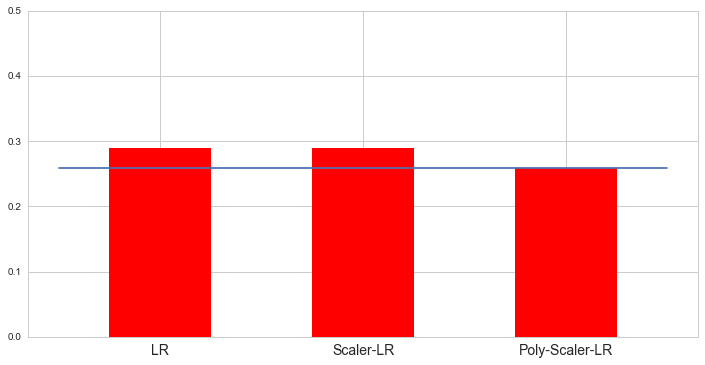

In [48]:
import numpy as np
results = -1 * np.array([best_1, best_2, best_3])
labs = ['LR', 'Scaler-LR', 'Poly-Scaler-LR']

fig = plt.figure(facecolor = 'w', figsize = (12, 6))
ax = plt.subplot(111)

width = 0.5
ind = np.arange(3)
rec = ax.bar(ind + width, results, width, color='r')

ax.set_xticks(ind + width)
ax.set_xticklabels(labs, size = 14)
ax.set_ylim([0.0, 0.5])

plt.plot(np.arange(4), min(results) * np.ones(4))

In [49]:
predictions = lr_grid_search_poly.best_estimator_.predict(X_test)
print(accuracy_score(y_test, predictions))

0.917857142857


In [53]:
print cross_val_score(lr_grid_search_poly.best_estimator_, X_train, y_train, cv=10)

[ 0.92        0.89732143  0.86160714  0.89285714  0.87946429  0.92857143
  0.87892377  0.89686099  0.87892377  0.91479821]


###  Random Forest

In [200]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier()

parameters = {'n_estimators': [10,20,25], 
              'max_features': [10,11,12], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [6, 8, 10,12], 
              'min_samples_split': [20, 30, 50],
              'min_samples_leaf': [3,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [201]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.901785714286


In [202]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.866666666667
Fold 2 accuracy: 0.85393258427
Fold 3 accuracy: 0.898876404494
Fold 4 accuracy: 0.865168539326
Fold 5 accuracy: 0.943820224719
Fold 6 accuracy: 0.85393258427
Fold 7 accuracy: 0.85393258427
Fold 8 accuracy: 0.921348314607
Fold 9 accuracy: 0.85393258427
Fold 10 accuracy: 0.921348314607
Mean Accuracy: 0.88329588015
